In [210]:
library(dplyr)
library(tibble)
library(tidyr)
library(umap)

library(RColorBrewer)
library(ggplot2)
library(cowplot)
theme_set(theme_bw())

In [68]:
options(repr.plot.width = 8, repr.plot.height = 4)

In [209]:
# source files
src_files <- list.files('../R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}

Sourced file: ../R/calc.R
Sourced file: ../R/misc.R
Sourced file: ../R/normalise.R
Sourced file: ../R/plot.R
Sourced file: ../R/predict.R
Sourced file: ../R/subset.R
Sourced file: ../R/utils.R


## Import data

In [4]:
# Metadata
METADATA_SID <- "../data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')

## Data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")

In [90]:
# Metadata
metadata_sid$label <- as.factor(metadata_sid$label)
levels(metadata_sid$label) <- c('Remission', 'Relapse')
metadata_sid$batch_info <- as.factor(metadata_sid$batch_info) 
metadata_pid$label <- as.factor(metadata_pid$label)
levels(metadata_pid$label) <- c('Remission', 'Relapse')

# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

# All features
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Commonly used globals

#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [91]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")
names(COL_LABEL) <- c('Remission', 'Relapse')

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 'Remission']
sid_normal <- paste0("N0", c(1,2,4))

## Affy mean scaling

## Removal of batch 3

In [193]:
# is_affy <- startsWith(rownames(raw_yeoh), 'AFFX')
# lg_affy <- log2_transform(raw_yeoh[is_affy, ])
# # hist(rowSums(lg_affy), breaks = 20)

# # selecting affy probesets with high expression (positive controls)
# idx_affy <- rownames(lg_affy)[rowSums(lg_affy) > 1000]
# raw_affy <- raw_yeoh[idx_affy, ]

# # affy mean scaling
# mean_affy <- colSums(raw_affy) / colSums(raw_affy != 0)
# scale_factor <- 500 / mean_affy
# affyms_yeoh <- sweep(raw_yeoh, 2, scale_factor, `*`)

In [194]:
# log_affyms_yeoh <- affyms_yeoh %>%
#   removeProbesets() %>%
#   filterProbesets(0.7, metadata_sid) %>%
#   log2_transform()

# # no features with missing values
# log_affyms_nozero_yeoh <- log_affyms_yeoh[rowSums(log_affyms_yeoh == 0) == 0, ]

[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Train/test split: Patients distribution

In [14]:
# # TODO: Do not evaluate to heterogeneous subtypes
# train_distr <- table(
#   Y[sid_train, "subtype"],
#   Y[sid_train, "label"]
# )/2
# test_distr <- table(
#   Y[sid_test, "subtype"],
#   Y[sid_test, "label"]
# )/2

# # # Transfer all relapse samples to test set
# # test_distr[, 2]<- test_distr[, 2] + train_distr[, 2]
# # train_distr[, 2] <- 0

# print(xtable(train_distr, display = rep("d", 3)))
# print(xtable(test_distr, display = rep("d", 3)))

## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [92]:
batch_ps <- identify_batch_features(yeoh, metadata, method = 'aov')
length(batch_ps)

[1] "No. of NaNs = 0"


[1] 2565

In [25]:
batch_ps1 <- identify_batch_features(log_affyms_yeoh, metadata, method = 'aov')
length(batch_ps1)

[1] "No. of NaNs = 0"


[1] 3166

In [75]:
batch_ps2 <- identify_batch_features(log_affyms_nobatch3, metadata, method = 'aov')
length(batch_ps2)

[1] "No. of NaNs = 0"


[1] 2812

### Drug genes

Constant: Subtype, remission

### M1: Entire data

In [195]:
# Affy mean scaling - No batch 3 and no features with missing values
# Without removing batch effect ps
log_affyms_nozero_nobatch3 <- subset_cols(
  log_affyms_nozero_yeoh, metadata_sid,
  batch_info != 3 & !(colnames(log_affyms_nozero_yeoh) %in% sid_mrd_na)
)
X_normal <- log_affyms_nozero_nobatch3[, sid_normal]

list_X_subtypes7 <- lapply(subtypes7, function(s) {
  log_affyms_nozero_nobatch3[
    , metadata_sid[colnames(log_affyms_nozero_nobatch3), "subtype"] == s]
})
affyms_nobatch3_nozero_woBE <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata_sid,
  metadata_pid
)
names(affyms_nobatch3_nozero_woBE) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 264
No. of features (p-value) = 108
No. of features (log2-fc) = 23
No. of DE features = 3
No. of final features = 3
No. of samples in centroid = 4
P055_D8 has a negative comp_LN_D8N!
 P056_D8 has a negative comp_LN_D8N!
 P057_D8 has a negative comp_LN_D8N!
 P170_D8 has a negative comp_LN_D8N!
 P175_D8 has a negative comp_LN_D8N!
 P184_D8 has a negative comp_LN_D8N!
No. of remission samples in training set = 4
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 320
No. of features (p-value) = 210
No. of features (log2-fc) = 93
No. of DE features = 49
No. of final features = 49
No. of samples in centroid = 4
P161_D8 has a negative comp_LN_D8N!
No. of remission samples in training set = 4
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 270
No. of features (p-value) = 756
No. of features (log2-fc) = 20
No. of DE fe

In [187]:
# Affy mean scaling - No batch 3
# With or without removing batch effect ps
log_affyms_nobatch3 <- subset_cols(
  log_affyms_yeoh, metadata_sid,
  batch_info != 3 & !(colnames(log_affyms_yeoh) %in% sid_mrd_na)
)
X_normal <- log_affyms_nobatch3[, sid_normal]

list_X_subtypes7 <- lapply(subtypes7, function(s) {
  log_affyms_nobatch3[
    , metadata_sid[colnames(log_affyms_nobatch3), "subtype"] == s]
})
affyms_nobatch3_woBE <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata_sid,
  metadata_pid
)
names(affyms_nobatch3_woBE) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 3427
No. of features (p-value) = 284
No. of features (log2-fc) = 100
No. of DE features = 20
No. of final features = 20
No. of samples in centroid = 4
P055_D8 has a negative comp_LN_D8N!
 P170_D8 has a negative comp_LN_D8N!
No. of remission samples in training set = 4
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 3559
No. of features (p-value) = 517
No. of features (log2-fc) = 338
No. of DE features = 104
No. of final features = 104
No. of samples in centroid = 4
P161_D8 has a negative comp_LN_D8N!
No. of remission samples in training set = 4
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 3455
No. of features (p-value) = 2422
No. of features (log2-fc) = 109
No. of DE features = 109
No. of final features = 109
No. of samples in centroid = 27
No. of remission samples in training set = 27
Prediction complet

In [27]:
# Affy mean scaling - All samples
X_normal <- log_affyms_yeoh[, sid_normal]
list_X_subtypes7 <- lapply(subtypes7, function(subtype) {
  log_affyms_yeoh[
    , sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
})

list_obj1 <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps1
)
names(list_obj1) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 3403
No. of features (p-value) = 108
No. of features (log2-fc) = 82
No. of DE features = 10
No. of final features = 4
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 3430
No. of features (p-value) = 748
No. of features (log2-fc) = 340
No. of DE features = 157
No. of final features = 109
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 3414
No. of features (p-value) = 2448
No. of features (log2-fc) = 98
No. of DE features = 98
No. of final features = 82
No. of samples in centroid = 31
No. of remission samples in training set = 31
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 3321
No. of features (p-value) =

In [16]:
# list_subtype_sids <- lapply(
#   subtypes7,
#   function(subtype) {
#     sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]
#   }
# )

In [118]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_obj <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps
)
names(list_obj) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 14
No. of samples in centroid = 5
P152_D8 has a negative comp_LN_D8N!
 P170_D8 has a negative comp_LN_D8N!
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 818
No. of features (p-value) = 744
No. of features (log2-fc) = 753
No. of DE features = 239
No. of final features = 164
No. of samples in centroid = 5
P161_D8 has a negative comp_LN_D8N!
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 718
No. of features (p-value) = 2508
No. of features (log2-fc) = 283
No. of DE features = 281
No. of final features = 216
No. of samples in centroid = 31
No. of remission samples in training set = 31
Prediction complete!


### Plot boxplots (comparing labels)

In [ ]:
list_X_y <- lapply(list_obj, function(obj) obj$X_y)
boxplots <- lapply(list_X_y, plot_boxplot, fill = 'label', p.value = FALSE)
names(boxplots) <- subtypes7

In [562]:
for (subtype in subtypes7) {
  file <- sprintf('~/Dropbox/tmp/boxplot-%s.pdf', subtype)
  ggsave(file, boxplots[[subtype]], width = 9.5, height = 2.5)
}

In [207]:
# Affy mean scaling - No batch 3
list_X_y <- lapply(affyms_nobatch3_nozero_woBE, function(obj) obj$X_y)
boxplots <- lapply(list_X_y, plot_boxplot, fill = 'label', p.value = FALSE)
names(boxplots) <- subtypes7

In [ ]:
for (subtype in subtypes7) {
  file <- sprintf('~/Dropbox/tmp/boxplot_affyms_nobatch3_nozero-%s.pdf', subtype)
  ggsave(file, boxplots[[subtype]], width = 9.5, height = 2.5)
}

### Calculate effect size
#### Cohen's d (assuming unequal variance)
$ d = \frac{x_1 - x_2}{s} $, $ s = \sqrt{\frac{s_1^2 + s_2^2}{2}} $

In [188]:
list_X_y <- lapply(affyms_nobatch3_woBE, function(obj) obj$X_y)
boxplots <- lapply(list_X_y, plot_boxplot, fill = 'label', p.value = FALSE)
names(boxplots) <- subtypes7

### Save probabilities (w/o heterogeneous subtypes)

In [68]:
list_p_d8 <- lapply(list_obj, function(obj) obj$X_y["p_d8"])
p_d8 <- do.call(rbind, unname(list_p_d8[subtypes5]))

In [69]:
list_p_d33 <- lapply(list_obj, function(obj) obj$X_y["p_d33"])
p_d33 <- do.call(rbind, unname(list_p_d33[subtypes5]))

In [70]:
write.table(p_d8, "../tmp/p_d8.tsv", quote = F, sep = "\t")
write.table(p_d33, "../tmp/p_d33.tsv", quote = F, sep = "\t")

## Plot: Relapse OR HR v.s. Remission AND NOT HR
- Change label column

In [134]:
add_treatment <- function(obj, metadata_pid) {
  # Adds column - required_treatment: {non-intensive, intensive}
  X_y <- obj$X_y
  treatment <- as.character(metadata_pid[rownames(X_y), 'treatment_processed'])
  names(treatment) <- rownames(X_y)
  treatment <- treatment[!is.na(treatment)] # remove NA values in treatment
  consolidated_treatment <- treatment
  idx <- consolidated_treatment %in% c('HR1', 'HR2')
  consolidated_treatment[idx] <- 'HR'
  consolidated_treatment[!idx] <- 'SR/IR'
  required_treatment <- factor(
    'Non-intensive',
    levels = c('Non-intensive', 'Intensive')
  )
  pid_info <- data.frame(
    treatment,
    consolidated_treatment,
    label = X_y[names(treatment), 'label'],
    required_treatment = required_treatment
  )
  idx_intensive <- pid_info$label == 'Relapse' | pid_info$consolidated_treatment == 'HR'
  pid_info$required_treatment[idx_intensive] <- 'Intensive'
  
  X_y <- X_y[rownames(pid_info), ] # remove patients with treatment NA values
  X_y$treatment <- pid_info$treatment
  X_y$required_treatment <- pid_info$required_treatment # add column to X_y
  
  return(X_y)
}

In [671]:
list_X_y1 <- lapply(list_obj, add_treatment, metadata_pid)

boxplots1 <- lapply(
  list_X_y1, plot_boxplot,
  group = 'required_treatment', fill = 'label', pch = 'treatment'
)

Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning me

In [137]:
# Affy mean scaling
list_X_y1 <- lapply(list_obj2, add_treatment, metadata_pid)

boxplots1 <- lapply(
  list_X_y1, plot_boxplot,
  group = 'required_treatment', fill = 'label', pch = 'treatment', p.value = FALSE
)

$Others


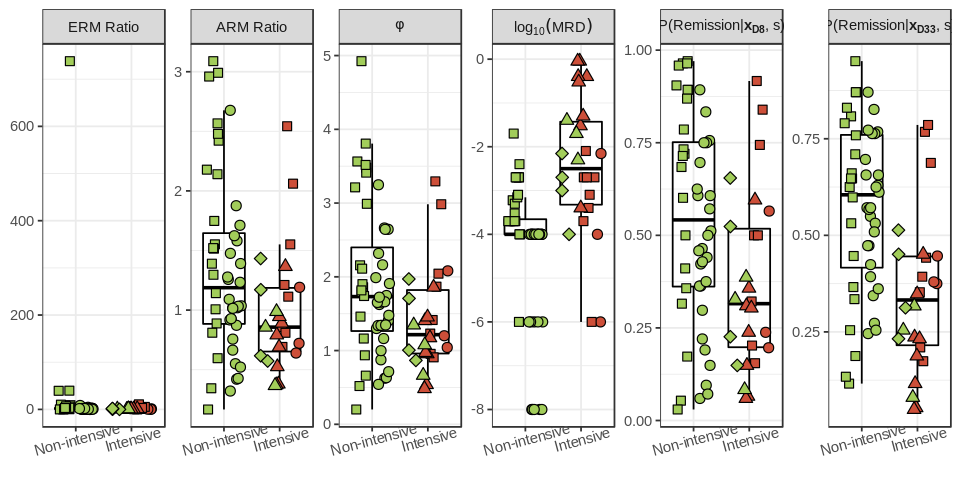

In [140]:
boxplots1['Others']

In [672]:
for (subtype in subtypes7) {
  file <- sprintf('~/Dropbox/tmp/boxplot_newlabel-%s.pdf', subtype)
  ggsave(file, boxplots1[[subtype]], width = 9.5, height = 2.5)
}

### Estimate probabilities (with Wk12 MRD)

In [59]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_obj1 <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  include_tp2 = TRUE
)
names(list_obj1) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 14
No. of samples in centroid = 5
Omitted patients: P054!
 Omitted patients: P134!
 Omitted patients: P170!
 Omitted patients: P184!
No. of remission samples in training set = 3
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 818
No. of features (p-value) = 744
No. of features (log2-fc) = 753
No. of DE features = 239
No. of final features = 164
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 718
No. of features (p-value) = 2508
No. of features (log2-fc) = 283
No. of DE features = 281
No. of final features = 216
No. of samples in centroid = 31
Omitted patients: P038!
 Omitted patients: P041!
 Omitted patients: P046!
 Om

In [71]:
list_p_tp2 <- lapply(list_obj1, function(obj) obj$X_y["p_tp2"])
p_tp2 <- do.call(rbind, unname(list_p_tp2[subtypes5]))

In [72]:
write.table(p_tp2, "../tmp/p_tp2.tsv", quote = F, sep = "\t")

#### Estimate probability using simulated samples
- Features are modelled as normal distributions (median, sd)

In [338]:
# list_obj2 <- lapply(
#   list_X_subtypes7,
#   predict_pipeline,
#   X_normal,
#   metadata, metadata_pid,
#   batch_ps,
#   samples = 300
# )
# names(list_obj2) <- subtypes7

### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

### M1: Train/test

### M1: Test set 1 (w/o Hyp, Others)

In [36]:
names(list_X_subtypes7) <- subtypes7
list_X_subtypes5 <- list_X_subtypes7[subtypes5]

In [37]:
list_train_test <- lapply(
  list_X_subtypes5,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  sid_train_test = list(sid_train, sid_test)
)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 760
No. of features (p-value) = 132
No. of features (log2-fc) = 326
No. of DE features = 24
No. of final features = 18
No. of samples in centroid = 4
No. of remission samples in training set = 4
No. of remission samples in training set = 4
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 1105
No. of features (p-value) = 356
No. of features (log2-fc) = 813
No. of DE features = 123
No. of final features = 79
No. of samples in centroid = 3
No. of remission samples in training set = 3
No. of remission samples in training set = 3
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 384
No. of features (p-value) = 459
No. of features (log2-fc) = 1281
No. of DE features = 164
No. of final features = 109
No. of samples in centroid = 2
No. of remission samples in training set = 2
No. of remission samples in training set =

### Save probabilities

In [39]:
# list_p_d8_train <- lapply(list_train_test, function(obj) obj$train$X_y["p_d8"])
# p_d8_train <- do.call(rbind, unname(list_p_d8_train))

# list_p_d8_test <- lapply(list_train_test, function(obj) obj$test$X_y["p_d8"])
# p_d8_test <- do.call(rbind, unname(list_p_d8_test))
                         
list_p_d33_train <- lapply(list_train_test, function(obj) obj$train$X_y["p_d33"])
p_d33_train <- do.call(rbind, unname(list_p_d33_train))

list_p_d33_test <- lapply(list_train_test, function(obj) obj$test$X_y["p_d33"])
p_d33_test <- do.call(rbind, unname(list_p_d33_test))

In [40]:
# write.table(p_d8_train, "../tmp/p_d8-train.tsv", quote = F, sep = "\t")
# write.table(p_d8_test, "../tmp/p_d8-test.tsv", quote = F, sep = "\t")

write.table(p_d33_train, "../tmp/p_d33-train.tsv", quote = F, sep = "\t")
write.table(p_d33_test, "../tmp/p_d33-test.tsv", quote = F, sep = "\t")

## TEL-AML
- Demonstrate removal of batch effect probesets

In [566]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @param sid_train_test list of length 2 in the form of (sid_train, sid_test)
#' @return list containing prediction plot and vector coordinates
get_class_genes <- function(
  X_subtype,
  X_normal,
  metadata_sid,
  metadata_pid,
  sid_train_test = NULL,
  features = c(
    "erm1_ratio2", "l2norm_ratio2",
    "angle_LD0_LD8_ratio2", "log_mrd_d33"
  ),
  direction = c("<", "<", "<", ">")
) {
  if (!is.null(sid_train_test)) {
    stopifnot(length(sid_train_test) == 2)
    sid_train <- intersect(sid_train_test[[1]], colnames(X_subtype))
    sid_test <- intersect(sid_train_test[[2]], colnames(X_subtype))
    # assert that D0 and D8 samples match
    stopifnot(is_paired(sid_train))
    stopifnot(is_paired(sid_test))
  }
  sid_remission <- colnames(X_subtype)[
    metadata_sid[colnames(X_subtype), "label"] == 'Remission'
  ]
  # Feature selection
  # Identify DE features between D0 and D8 samples
  if (!is.null(sid_train_test)) {
    class_genes <- identify_DE(
      X_subtype[, sid_train, drop = FALSE],
      sid_remission
    )
  } else {
    class_genes <- identify_DE(X_subtype, sid_remission)
  }
  
  class_genes
}

In [567]:
names(list_X_subtypes7) <- subtypes7
telaml1 <- list_X_subtypes7[['TEL-AML1']]

In [568]:
telaml1_ps <- get_class_genes(telaml1, X_normal, metadata, metadata_pid)
selected_ps <- setdiff(telaml1_ps, batch_ps)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 710
No. of features (p-value) = 2765
No. of features (log2-fc) = 507


In [608]:
ax_top_pc1 <- ggplot_top_pc(
  telaml1[telaml1_ps, ], metadata, x_axis = 'batch_info',
  cex = 2.5, color = 'batch_info', pch = 'class_info'
) +
  labs(x = 'Batch', col = 'Batch', pch = 'Time point')

ax_top_pc2 <- ggplot_top_pc(
  telaml1[selected_ps, ], metadata, x_axis = 'batch_info',
  cex = 2.5, color = 'batch_info', pch = 'class_info'
) +
  labs(x = 'Batch', col = 'Batch', pch = 'Time point')

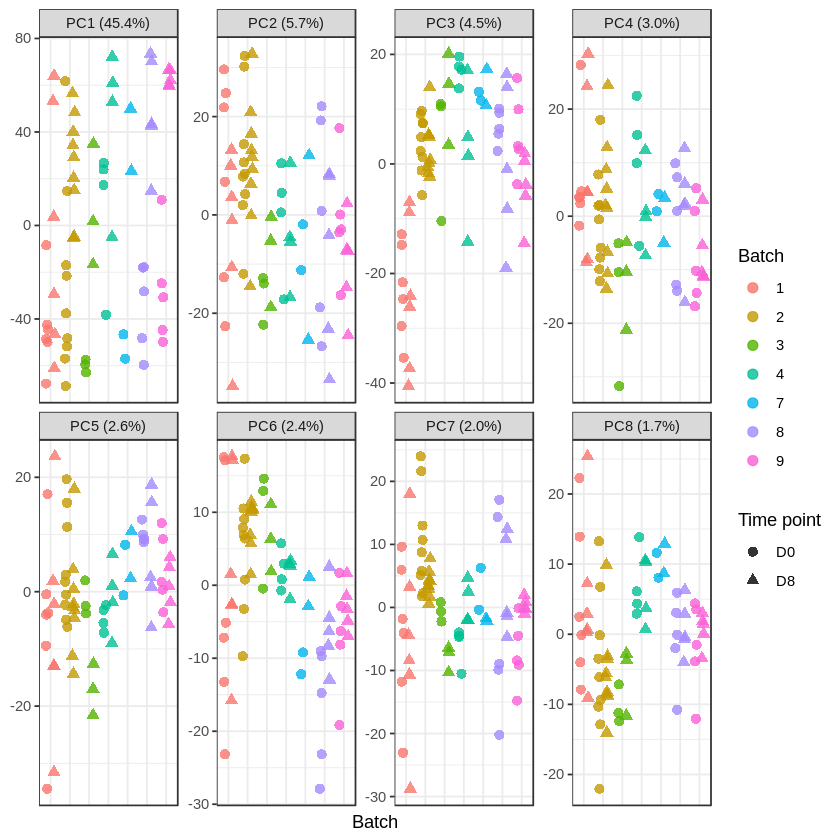

In [609]:
ax_top_pc1

In [611]:
file1 <- '~/Dropbox/tmp/top_pc-telaml1_before.pdf'
file2 <- '~/Dropbox/tmp/top_pc-telaml1_after.pdf'
ggsave(file1, ax_top_pc1, width = 8, height = 4)
ggsave(file2, ax_top_pc2, width = 8, height = 4)

In [204]:
ax_pca1 <- ggplot_pca(
  telaml1[telaml1_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')
ax_pca2 <- ggplot_pca(
  telaml1[selected_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')

In [ ]:
file1 <- '~/Dropbox/tmp/pca-telaml1_before.pdf'
file2 <- '~/Dropbox/tmp/pca-telaml1_after.pdf'
ggsave(file1, ax_pca1, width = 4.5, height = 3.5)
ggsave(file2, ax_pca2, width = 4.5, height = 3.5)

In [205]:
ax_umap1 <- ggplot_umap(
  telaml1[telaml1_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')
ax_umap2 <- ggplot_umap(
  telaml1[selected_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')

In [206]:
file1 <- '~/Dropbox/tmp/umap-telaml1_before.pdf'
file2 <- '~/Dropbox/tmp/umap-telaml1_after.pdf'
ggsave(file1, ax_umap1, width = 4.5, height = 3.5)
ggsave(file2, ax_umap2, width = 4.5, height = 3.5)

# DUX4

In [676]:
add_treatment <- function(obj, metadata_pid) {
  # Adds column - required_treatment: {non-intensive, intensive}
  X_y <- obj$X_y
  treatment <- as.character(metadata_pid[rownames(X_y), 'treatment_processed'])
  names(treatment) <- rownames(X_y)
  treatment <- treatment[!is.na(treatment)] # remove NA values in treatment
  consolidated_treatment <- treatment
  idx <- consolidated_treatment %in% c('HR1', 'HR2')
  consolidated_treatment[idx] <- 'HR'
  consolidated_treatment[!idx] <- 'SR/IR'
  required_treatment <- factor(
    'Non-intensive',
    levels = c('Non-intensive', 'Intensive')
  )
  pid_info <- data.frame(
    treatment,
    consolidated_treatment,
    label = X_y[names(treatment), 'label'],
    required_treatment = required_treatment
  )
  idx_intensive <- pid_info$label == 'Relapse' | pid_info$consolidated_treatment == 'HR'
  pid_info$required_treatment[idx_intensive] <- 'Intensive'
  
  X_y <- X_y[rownames(pid_info), ] # remove patients with treatment NA values
  X_y$treatment <- pid_info$treatment
  X_y$required_treatment <- pid_info$required_treatment # add column to X_y
  
  return(X_y)
}

In [704]:
X_y <- add_treatment(obj, metadata_pid)
head(X_y)

,erm1_ratio2,l2norm_ratio2,angle_LD0_LD8_ratio2,log_mrd_d33,p_d8,p_d33,label,treatment,required_treatment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
P060,2.2609633,1.3974799,0.5436946,-3.69897,0.3333333,0.4473684,Remission,IR,Non-intensive
P063,0.6173321,0.9174787,0.4324256,-3.00000,0.1052632,0.1973684,Remission,HR1,Intensive
P071,5.0548792,1.4634860,0.6214487,-2.69897,0.5263158,0.5000000,Remission,IR,Non-intensive
P073,2.3434004,1.3656135,0.6268032,-3.30103,0.3859649,0.4210526,Remission,IR,Non-intensive
P076,36.4452859,2.6607007,1.1706164,-3.69897,1.0000000,0.9473684,Remission,IR,Non-intensive
P077,2.5821853,1.4311605,0.6603660,-2.69897,0.4736842,0.4605263,Remission,HR1,Intensive


In [743]:
ax <- plot_boxplot(X_y, group = 'label', fill = 'label')
file <- "~/Dropbox/tmp/boxplot_outcome-DUX4.pdf"
ggsave(file, ax, width = 9.5, height = 2.5)

Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”